In [1]:
%%capture
%run ./calculations.ipynb
%run ../HATPRO/compare_radiosonde_hatpro_hobos.ipynb
%run ../HOBOs/hobos_read_in.ipynb
%run ../HATPRO/zeitreihe_hatpro.ipynb

#%run D:/codes/calculations.ipynb
#%run D:/codes/HATPRO/compare_radiosonde_hatpro_hobos.ipynb
#%run D:/codes/HOBOs/hobos_read_in.ipynb
#%run D:/codes/HATPRO/zeitreihe_hatpro.ipynb

In [2]:
from scipy import ndimage
import scipy.interpolate as interp
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
model = ['OBS','WRF','AROME','UM','ICON','ICON2TE']
labels = ["WRF", "AROME", "UM", "ICON", "ICON2TE"]
colours=[colordict['WRF_ACINN'], colordict['AROME'], colordict['UKMO'], colordict['ICON'], 'm']
colours_obs=[colordict['RADIOSONDE'], colordict['WRF_ACINN'], colordict['AROME'], colordict['UKMO'], colordict['ICON'], 'm']
formen=['o','*','+','x','<','^']

# Potential Temperature - height

In [4]:
# in which format is which model?
print(f"obs = {type(df_obs)}, arome = {type(df_arome)}, icon = {type(df_icon)}, um = {type(data_ukmo)}, wrf = {type(df_wrf_acinn)}")
df_wrf_acinn

obs = <class 'xarray.core.dataset.Dataset'>, arome = <class 'xarray.core.dataset.Dataset'>, icon = <class 'xarray.core.dataset.Dataset'>, um = <class 'pandas.core.frame.DataFrame'>, wrf = <class 'xarray.core.dataset.Dataset'>


<xarray.Dataset> Size: 4kB
Dimensions:            (bottom_top: 80)
Coordinates:
    west_east          float64 8B -3e+03
    south_north        float64 8B -4e+03
Dimensions without coordinates: bottom_top
Data variables: (12/13)
    p                  (bottom_top) float32 320B 9.583e+04 ... 4.283e+03
    th                 (bottom_top) float32 320B 292.8 293.4 ... 493.0 516.3
    q_mixingratio      (bottom_top) float32 320B 0.006843 0.006749 ... 2.887e-06
    u                  (bottom_top) float32 320B -1.155 -0.5713 ... 1.279 1.961
    v                  (bottom_top) float32 320B -0.0852 -0.167 ... 0.3243 -2.95
    z                  (bottom_top) float32 320B 592.6 613.5 ... 2.159e+04
    ...                 ...
    temperature        (bottom_top) float32 320B 16.1 16.49 ... -65.1 -63.26
    relative_humidity  (bottom_top) float32 320B 57.02 54.73 ... 2.345 1.605
    dewpoint           (bottom_top) float32 320B 7.593 7.356 ... -89.12 -89.85
    specific_humidity  (bottom_top) float32 320B 6.797 6.704 ... 0.002887
    ff                 (bottom_top) float32 320B 1.158 0.5952 ... 1.32 3.542
    dd                 (bottom_top) float32 320B 85.78 73.71 ... 255.8 326.4

In [5]:
obs_th = potential_temperature(df_obs.pressure, df_obs.temperature)
wrf_th = potential_temperature(df_wrf_acinn.pressure, df_wrf_acinn.temperature)
arome_th = potential_temperature(df_arome.pressure, df_arome.temperature)
ukmo_th = potential_temperature(data_ukmo.to_xarray().pressure*units('hPa'), (data_ukmo.to_xarray().temperature+273.15)*units('K'))
icon_th = potential_temperature(df_icon.pressure*units('hPa'), df_icon.temperature*units('degree_Celsius'))
icon2TE_th = potential_temperature(df_icon2TE.pressure*units('hPa'), df_icon2TE.temperature*units('degree_Celsius'))


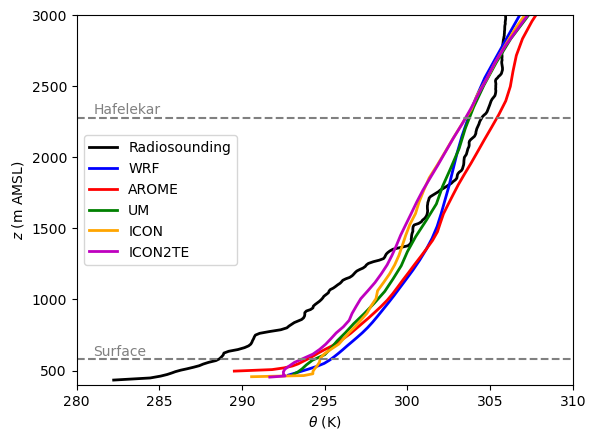

In [6]:
fig = plt.figure()

plt.plot(obs_th[::-1], pressure_to_height_std(df_obs["pressure"].values[::-1] * units('hPa')) * 1000, 
         color=colordict["RADIOSONDE"], label="Radiosounding", linewidth=2)
plt.plot(wrf_th, pressure_to_height_std(df_wrf_acinn["pressure"].values * units('hPa'))* 1000, 
         color=colordict["WRF_ACINN"], label="WRF", linewidth=2)
plt.plot(arome_th, pressure_to_height_std(df_arome["pressure"].values * units('hPa'))* 1000, 
         color=colordict["AROME"], label="AROME", linewidth=2)
plt.plot(ukmo_th[::-1], pressure_to_height_std(data_ukmo["pressure"].values[::-1] * units('hPa'))* 1000, 
         color=colordict["UKMO"],label="UM", linewidth=2)
plt.plot(icon_th, pressure_to_height_std(df_icon["pressure"].values * units('hPa'))* 1000, 
         color=colordict["ICON"], label="ICON", linewidth=2)
plt.plot(icon2TE_th.values, pressure_to_height_std(df_icon2TE["pressure"].values * units('hPa'))* 1000, 
         color='m', label="ICON2TE", linewidth=2)
plt.axhline(y = z_seg[0], color = 'grey', linestyle = '--') 
plt.axhline(y = z_surf[0], color = 'grey', linestyle = '--') 

#plt.title(f"Potential Temperature")
plt.xlabel(r'$\theta$ (K)')
plt.ylabel('$z$ (m AMSL)')
plt.ylim(400, 3000)
plt.xlim(280,310)
plt.text(281, z_surf[0] + 30, 'Surface', color = 'grey',)
plt.text(281, z_seg[0] + 30, 'Hafelekar', color = 'grey',)
plt.legend();
plt.savefig(dir_PLOTS + "results/potential_T_height.svg")


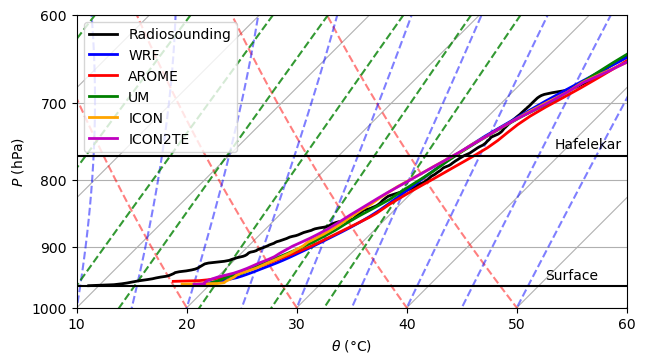

In [20]:
fig = plt.figure(figsize=(10,10))
skew = SkewT(fig, rotation=45, rect=(0.1, 0.1, 0.55, 0.85))

skew.plot((df_obs["pressure"].values), np.array(obs_th)-273.15,color=colordict["RADIOSONDE"], label="Radiosounding", linewidth=2)
skew.plot((df_wrf_acinn["pressure"].values),np.array(wrf_th)-273.15, color=colordict["WRF_ACINN"], label="WRF",linewidth=2)
skew.plot((df_arome["pressure"].values), np.array(arome_th)-273.15, color=colordict["AROME"], label="AROME", linewidth=2)
skew.plot((data_ukmo["pressure"].values[::-1]), np.array(ukmo_th[::-1])-273.15, color=colordict["UKMO"],label="UM", linewidth=2)
skew.plot((df_icon["pressure"].values), np.array(icon_th)-273.15, color=colordict["ICON"], label="ICON", linewidth=2)
skew.plot((df_icon2TE["pressure"].values), np.array(icon2TE_th.values)-273.15, color='m', label="ICON2TE", linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

#plt.title(f"Potential Temperature")
skew.ax.set_xlabel(r'$\theta$ (°C)')
skew.ax.set_ylabel('$P$ (hPa)')
skew.ax.set_xlim(10, 60)
skew.ax.set_ylim(1000, 600)

#change size of fig
skew.ax.set_aspect(120)

skew.ax.axhline(y=p_seg, color='k')
skew.ax.axhline(y=p_surf[0], color='k')
skew.ax.text(50, p_surf[0]-10, 'Surface')
skew.ax.text(39, p_seg -10, 'Hafelekar')

plt.legend();
plt.savefig(dir_PLOTS + "results/potential_T_press.png")


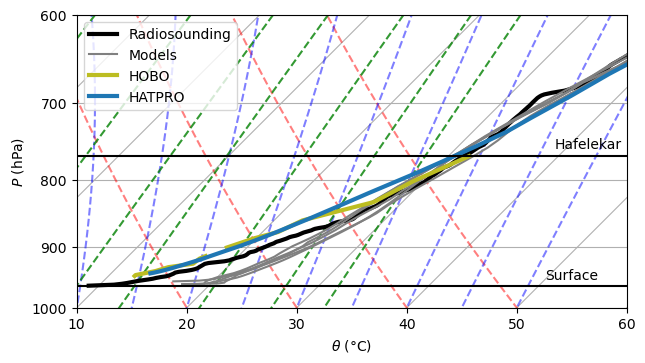

In [21]:
fig = plt.figure(figsize=(10,10))
skew = SkewT(fig, rotation=45, rect=(0.1, 0.1, 0.55, 0.85))

skew.plot((df_obs["pressure"].values), np.array(obs_th)-273.15,color=colordict["RADIOSONDE"], 
          label="Radiosounding", linewidth=3)
skew.plot((df_wrf_acinn["pressure"].values),np.array(wrf_th)-273.15, color='grey', label="Models",linewidth=1.5)
skew.plot((df_arome["pressure"].values), np.array(arome_th)-273.15, color='grey', linewidth=1.5)
skew.plot((data_ukmo["pressure"].values[::-1]), np.array(ukmo_th[::-1])-273.15,color='grey', linewidth=1.5)
skew.plot((df_icon["pressure"].values), np.array(icon_th)-273.15, color='grey', linewidth=1.5)
skew.plot((df_icon2TE["pressure"].values), np.array(icon2TE_th.values)-273.15, color='grey', linewidth=1.5)

#HOBO
skew.plot(height_to_pressure_std(heights* units('m')).magnitude,
          potential_temperature(height_to_pressure_std(heights* units('m')), temperatures*units('degree_Celsius'))
          .magnitude-273.15, color='tab:olive', label='HOBO', linewidth=3)
#HATPRO
skew.plot(height_to_pressure_std(subset.height_level* units('m')),
          potential_temperature(height_to_pressure_std(subset.height_level* units('m')), 
                                subset.T).values-273.15,color='tab:blue', label="HATPRO", linewidth=3)


# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

#plt.title(f"Potential Temperature")
skew.ax.set_xlabel(r'$\theta$ (°C)')
skew.ax.set_ylabel('$P$ (hPa)')
skew.ax.set_xlim(10, 60)
skew.ax.set_ylim(1000, 600)

#change size of fig
skew.ax.set_aspect(120)

skew.ax.axhline(y=p_seg, color='k')
skew.ax.axhline(y=p_surf[0], color='k')
skew.ax.text(50, p_surf[0]-10, 'Surface')
skew.ax.text(39, p_seg -10, 'Hafelekar')



plt.legend();
plt.savefig(dir_PLOTS + "results/all_potential_T_press.png")


In [22]:
def find_nearest_and_index(data, nearest):
    for index, value in enumerate(data):
        if value == find_nearest(data, nearest):
            return(index)

# SKEW-T

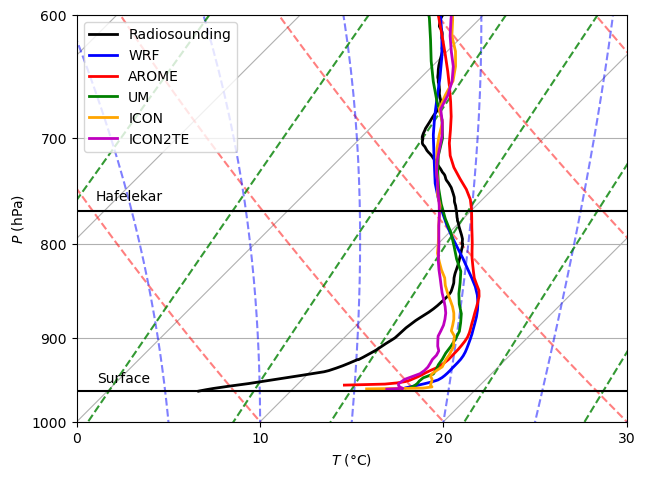

In [24]:
fig = plt.figure(figsize=(10,20))
skew = SkewT(fig, rotation=45, rect=(0.1, 0.1, 0.55, 0.85))

skew.plot(df_obs["pressure"].values, np.convolve(np.ones(35)/35, df_obs["temperature"].values, 'same'), color=colordict["RADIOSONDE"], label="Radiosounding", linewidth=2)
skew.plot(df_wrf_acinn["pressure"].values, df_wrf_acinn["temperature"].values, color=colordict["WRF_ACINN"], label="WRF",linewidth=2)
skew.plot(df_arome["pressure"].values, df_arome["temperature"].values, color=colordict["AROME"], label="AROME", linewidth=2)
skew.plot(data_ukmo["pressure"].values, data_ukmo["temperature"].values, color=colordict["UKMO"],label="UM", linewidth=2)
skew.plot(df_icon["pressure"].values, df_icon["temp"].values-273.15, color=colordict["ICON"], label="ICON", linewidth=2)
skew.plot(df_icon2TE["pressure"].values, df_icon2TE["temp"].values-273.15, color='m', label="ICON2TE", linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# plt.title(
#     f"Model time {pd.to_datetime(time_for_model).strftime('%Y-%m-%d %H:%M')}, Launch time: {pd.to_datetime(launch_date).strftime('%Y-%m-%d %H:%M')}")

skew.ax.set_xlabel('$T$ (°C)')
skew.ax.set_ylabel('$P$ (hPa)')

skew.ax.set_xlim(0, 30)
skew.ax.set_ylim(1000, 600)

#change size of fig
skew.ax.set_aspect(100)

skew.ax.axhline(y=p_seg, color='k')
skew.ax.axhline(y=p_surf[0], color='k')
skew.ax.text(-1, p_surf[0]-10, 'Surface')
skew.ax.text(-11, p_seg -10, 'Hafelekar')
#skew.ax.axhline(y=df_obs.pressure[81].values, color='k')
#skew.ax.margins(y=10)
plt.legend(loc=2);
plt.savefig(dir_PLOTS + "results/skew_t_zoomed_in.svg")
plt.savefig(dir_PLOTS + "results/skew_t_zoomed_in.png")


# Winds

In [25]:
ff = [ff_obs, ff_wrf_helen, ff_arome, ff_ukmo, ff_icon, ff_icon2TE]
dd = [dd_obs, dd_wrf_helen, dd_arome, dd_ukmo, dd_icon, dd_icon2TE]

In [26]:
obs_ff_surfseg = ff_obs[0:find_nearest_and_index(df_obs.pressure.values, p_seg)]
wrf_ff_surfseg = ff_wrf_helen[0:find_nearest_and_index(df_wrf_acinn.pressure.values, p_seg)]
arome_ff_surfseg = ff_arome[::-1][0:find_nearest_and_index(df_arome.pressure[::-1].values, p_seg)]
ukmo_ff_surfseg = ff_ukmo[0:find_nearest_and_index(data_ukmo.pressure.values, p_seg)]
icon_ff_surfseg = ff_icon[::-1][0:find_nearest_and_index(df_icon.pressure[::-1].values, p_seg)]
icon2TE_ff_surfseg = ff_icon2TE[::-1][0:find_nearest_and_index(df_icon2TE.pressure[::-1].values, p_seg)]

ff_surfseg = [obs_ff_surfseg, wrf_ff_surfseg, arome_ff_surfseg, ukmo_ff_surfseg,
             icon_ff_surfseg, icon2TE_ff_surfseg]

In [27]:
obs_ff_surfmax = ff_obs[0:find_nearest_and_index(df_obs.pressure.values, p_max[0])]
wrf_ff_surfmax = ff_wrf_helen[0:find_nearest_and_index(df_wrf_acinn.pressure.values, p_max[1])]
arome_ff_surfmax = ff_arome[::-1][0:find_nearest_and_index(df_arome.pressure[::-1].values, p_max[2])]
ukmo_ff_surfmax = ff_ukmo[0:find_nearest_and_index(data_ukmo.pressure.values, p_max[3])]
icon_ff_surfmax = ff_icon[::-1][0:find_nearest_and_index(df_icon.pressure[::-1].values, p_max[4])]
icon2TE_ff_surfmax = ff_icon2TE[::-1][0:find_nearest_and_index(df_icon2TE.pressure[::-1].values, p_max[5])]

ff_surfmax = [obs_ff_surfmax, wrf_ff_surfmax, arome_ff_surfmax, ukmo_ff_surfmax,
             icon_ff_surfmax, icon2TE_ff_surfmax]

In [28]:
obs_dd_surfseg = dd_obs[0:find_nearest_and_index(df_obs.pressure.values, p_seg)]
wrf_dd_surfseg = dd_wrf_helen[0:find_nearest_and_index(df_wrf_acinn.pressure.values, p_seg)]
arome_dd_surfseg = dd_arome[::-1][0:find_nearest_and_index(df_arome.pressure[::-1].values, p_seg)]
ukmo_dd_surfseg = dd_ukmo[0:find_nearest_and_index(data_ukmo.pressure.values, p_seg)]
icon_dd_surfseg = dd_icon[::-1][0:find_nearest_and_index(df_icon.pressure[::-1].values, p_seg)]
icon2TE_dd_surfseg = dd_icon2TE[::-1][0:find_nearest_and_index(df_icon2TE.pressure[::-1].values, p_seg)]

dd_surfseg = [obs_dd_surfseg, wrf_dd_surfseg, arome_dd_surfseg, ukmo_dd_surfseg,
             icon_dd_surfseg, icon2TE_dd_surfseg]

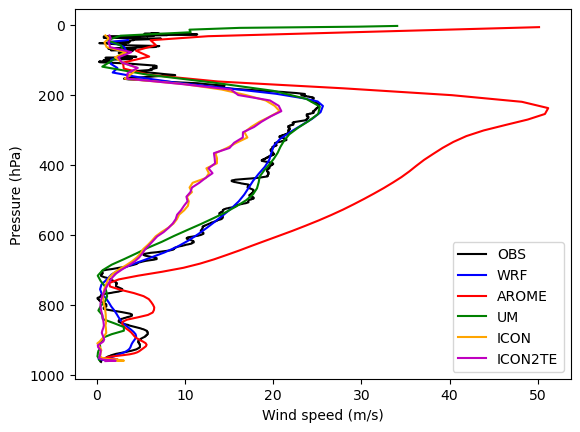

In [29]:
for i in range(6):
    plt.plot(ff[i], press[i],color=colours_obs[i], label=model[i])
plt.ylabel("Pressure (hPa)")
plt.xlabel("Wind speed (m/s)")
plt.gca().invert_yaxis()
plt.legend();
#plt.title("Wind Speed");

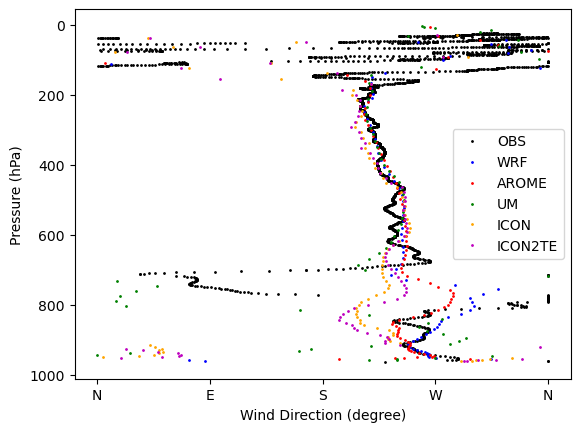

In [30]:
fig, ax = plt.subplots()
for i in range(6):
    ax.plot(dd[i], press[i],'.',markersize=2, color=colours_obs[i],label=model[i])
plt.ylabel("Pressure (hPa)")
plt.xlabel("Wind Direction (degree)")
plt.gca().invert_yaxis()
plt.legend()
#plt.title("Wind Direction");
xticks = np.arange(0, 361, 90)
xtick_labels = ['N', 'E', 'S', 'W', 'N']
plt.xticks(xticks)
ax.set_xticklabels(xtick_labels);

# N - theta

In [31]:
N = np.zeros(6)
for i in range(6):
    N[i] = bv_freq(th_surf[i], th_max[i], z_surf[i], z_max[i])

In [32]:
#ff_diff = np.zeros(6)
z_diff_max_surf = np.zeros(6)
non_dim_m_H = np.zeros(6)
ff_max = np.zeros(6)
for i in range(6):
    #ff_diff[i] = ff_surfmax[i][-1] - ff_surfmax[i][0]
    z_diff_max_surf[i] = z_max[i]-z_surf[i]
    ff_max[i] = ff_surfmax[i][-1]
    
    non_dim_m_H[i] = non_dim_m_h(N[i], z_diff_max_surf[i], ff_max[i])

NameError: name 'non_dim_m_h' is not defined

# NH/U

In [33]:
def non_dim_m_h(N, h, U):
    return N*h /U   

In [34]:
#ff_diff = np.zeros(6)
z_diff_max_surf = np.zeros(6)
new_NHU = np.zeros(6)
ff_max = np.zeros(6)
ff_seg = np.zeros(6)

for i in range(6):
    #ff_diff[i] = ff_surfmax[i][-1] - ff_surfmax[i][0]
    z_diff_max_surf[i] = z_max[i]-z_surf[i]
    ff_max[i] = ff_surfmax[i][-1]
    ff_seg[i] = ff_surfseg[i][-1]
    
    new_NHU[i] = non_dim_m_h(N[i], z_diff_max_surf[i], ff_seg[i])

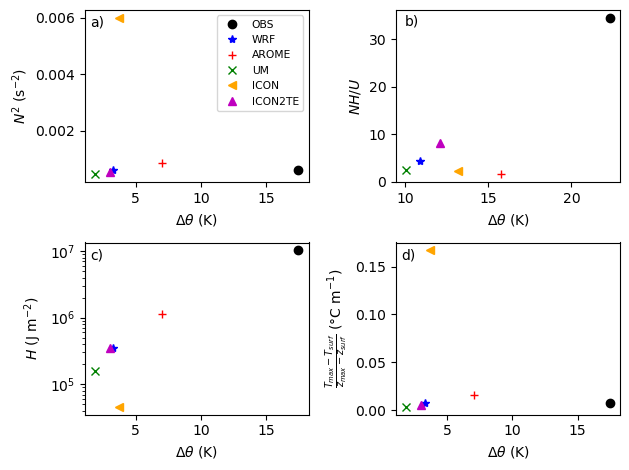

In [35]:
fig, ax = plt.subplots(2,2)

#N  
for i in range(6):
    l0 = ax[0,0].plot((th_max - th_surf).T.flatten()[i], (N**2)[i], formen[i],
        color=colours_obs[i], label=model[i])
ax[0,0].set_xlabel(r'$\Delta\theta$ (K)')
ax[0,0].set_ylabel(r'$N^2$ (s$^{-2}$)')
ax[0,0].legend(fontsize="7.75")
ax[0,0].text(1.5, .0057, 'a)')



#NH/U
for i in range(6):
    l1 = ax[0,1].plot((th_seg - th_surf).T.flatten()[i],new_NHU[i], formen[i],
            color=colours_obs[i], label=model[i])
ax[0,1].set_ylabel(r'$NH/U$')
ax[0,1].set_xlabel(r'$\Delta\theta$ (K)')
ax[0,1].text(10, 33, 'b)')



#valley heat def
for i in range(6):
    l2 = ax[1,0].plot((th_max - th_surf).T.flatten()[i],valley_heat_def(T_surf, T_max, z_surf, z_max).magnitude[i], formen[i],
            color=colours_obs[i], label=model[i])
ax[1,0].set_ylabel(r'$H$ (J m$^{-2})$')
ax[1,0].set_xlabel(r'$\Delta\theta$ (K)')
ax[1,0].text(1.5, 1e7-0.25*1e7, 'c)')
ax[1,0].set_yscale('log')


#bulk T grad
for i in range(6):
    l3 = ax[1,1].plot((th_max - th_surf).T.flatten()[i], ((T_max - T_surf) / (z_max - z_surf))[i], formen[i],
            color=colours_obs[i], label=model[i])
ax[1,1].set_ylabel(r'$\frac{T_{max} - T_{surf}}{z_{max} - z_{surf}}$ (°C m$^{-1})$')
ax[1,1].set_xlabel(r'$\Delta\theta$ (K)')
ax[1,1].text(1.5,.157, 'd)')

plt.tight_layout() #stop figures from overlapping
plt.show()
fig.savefig(dir_PLOTS + "results/parameter_relations.svg")


# HATPRO

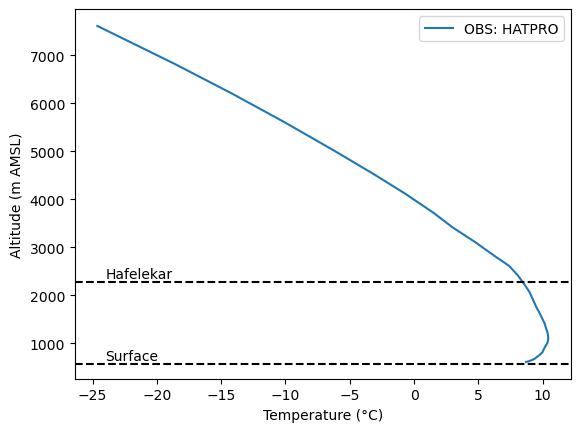

In [45]:
subset = df_hatpro.isel(rawdate=index)

plt.plot(subset.T, subset.height_level, label="OBS: HATPRO", color='tab:blue')
plt.xlabel('Temperature (°C)')
plt.ylabel('Altitude (m AMSL)')
#plt.title(f"Model time {pd.to_datetime(model_time).strftime('%Y-%m-%d %H:%M')}, HATPRO Time: {pd.to_datetime(hatpro_time).strftime('%Y-%m-%d %H:%M')}")

plt.axhline(y = z_seg[0], color = 'k', linestyle = '--') 
plt.axhline(y = z_surf[0], color = 'k', linestyle = '--') 

plt.text(-24, z_surf[0] + 70, 'Surface', color = 'k',)
plt.text(-24, z_seg[0] + 70, 'Hafelekar', color = 'k',)

plt.legend()

plt.savefig(dir_PLOTS + "HATPRO/HATPRO.png")

# HOBO - HATPRO - RADIOSONDE

In [37]:
T_HHR = [np.array(heights), np.array(subset.height_level), np.array(np.convolve(np.ones(35)/35, df_obs["temperature"].values, 'same')[::-1])]
z_HHR = [np.array(temperatures), np.array(subset.T), np.array(pressure_to_height_std(df_obs["pressure"].values[::-1] *units('hPa')) * 1000)]
#mean_squared_error(T_HHR, z_HHR)


In [38]:
#HOBOs
selected_time = "2017-10-16T03:00:00"
loc = "nord"
hobos_data_sorted = read_in_hobos(loc=loc, my_time=selected_time)
heights = [station_data['zsl'] for station_data in hobos_data_sorted.values()]
temperatures = [station_data['ta'] for station_data in hobos_data_sorted.values()]

In [39]:
hat_t = np.zeros(36)
for i in range(36):
    hat_t[i] = hatpro_selected_time.T[i][90] #90 for 2017-10-16T03:00:00
hat_t

array([  9.0451,   9.2753,   9.6124,   9.8906,  10.1994,  10.4539,
        10.7021,  10.9252,  11.2935,  11.558 ,  11.9373,  12.3165,
        12.5447,  12.6215,  12.6161,  12.5635,  12.464 ,  12.2663,
        12.0834,  11.7314,  11.4685,  11.2384,  10.8135,  10.2396,
         9.4769,   8.26  ,   6.3596,   4.4757,   2.9957,   0.6487,
        -1.7233,  -4.7973,  -8.5375, -12.5704, -16.6712, -22.5316])

In [40]:
#plt.plot(d, hatpro_selected_time.height_level, color='tab:blue', label="HATPRO", linewidth=2)


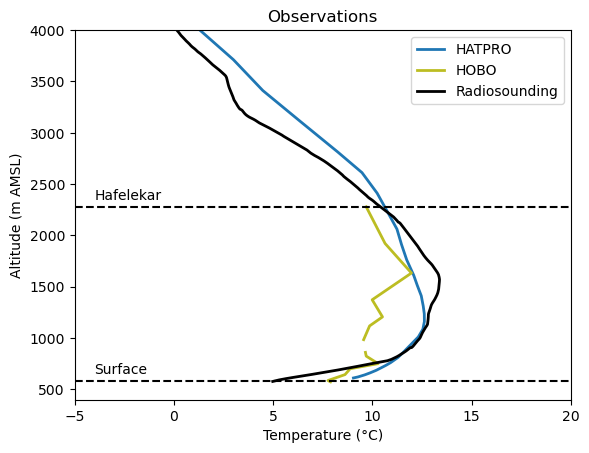

In [43]:
#HATPRO
subset = df_hatpro.isel(rawdate=index)
#plt.plot(subset.T, subset.height_level, color='tab:blue', label="HATPRO", linewidth=2)
plt.plot(hat_t, hatpro_selected_time.height_level, color='tab:blue', label="HATPRO", linewidth=2)

#HOBO
plt.plot(temperatures, heights, color='tab:olive', label='HOBO', linewidth=2)

#RADIOSONDE
plt.plot(np.convolve(np.ones(35)/35, df_obs["temperature"].values, 'same')[::-1],
         df_obs.height[::-1], 
         color=colordict["RADIOSONDE"], label="Radiosounding", linewidth=2)

#KWARGS
plt.xlabel('Temperature (°C)')
plt.ylabel('Altitude (m AMSL)')
plt.title(f"Observations")
plt.legend()

plt.axhline(y = z_seg[0], color = 'k', linestyle = '--') 
plt.axhline(y = z_surf[0], color = 'k', linestyle = '--') 

plt.text(-4, z_surf[0] + 70, 'Surface', color = 'k',)
plt.text(-4, z_seg[0] + 70, 'Hafelekar', color = 'k',)
#plt.ylim(0,max(subset.height_level).values)
plt.ylim(400,4e3)
plt.xlim(-5,20);

plt.savefig(dir_PLOTS + "results/all_observations.png")


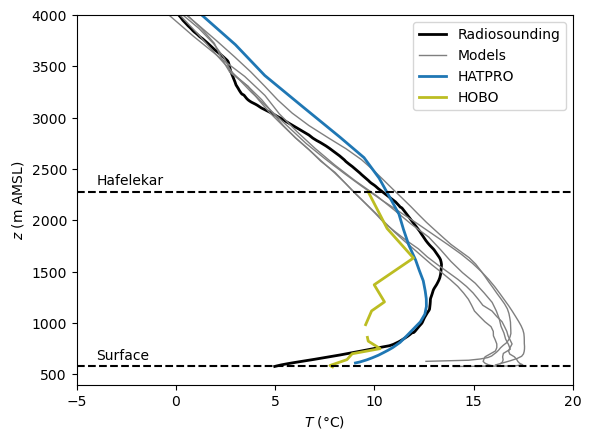

In [44]:
#RADIOSONDE
plt.plot(np.convolve(np.ones(35)/35, df_obs["temperature"].values, 'same')[::-1],df_obs.height[::-1], color=colordict["RADIOSONDE"], label="Radiosounding", linewidth=2)
plt.plot(df_wrf_acinn["temperature"].values, df_wrf_acinn.z, color='tab:grey', label="Models",linewidth=1)
plt.plot(df_arome["temperature"].values[::-1], df_arome.height[::-1], color='tab:grey', linewidth=1)
plt.plot(data_ukmo["temperature"].values, data_ukmo.geopotential_height, color='tab:grey', linewidth=1)
plt.plot(df_icon["temp"].values-273.15, np.delete(df_icon.z_ifc.values, 0), color='tab:grey', linewidth=1)
plt.plot(df_icon2TE["temp"].values-273.15, np.delete(df_icon2TE.z_ifc.values, 0), color='tab:grey', linewidth=1)


#HATPRO
plt.plot(hat_t, hatpro_selected_time.height_level, color='tab:blue', label="HATPRO", linewidth=2)


#HOBO
plt.plot(temperatures, heights, color='tab:olive', label='HOBO', linewidth=2)

#KWARGS
plt.xlabel('$T$ (°C)')
plt.ylabel('$z$ (m AMSL)')
#plt.title(f"Observations and models")
plt.legend()

plt.axhline(y = z_seg[0], color = 'k', linestyle = '--') 
plt.axhline(y = z_surf[0], color = 'k', linestyle = '--') 

plt.text(-4, z_surf[0] + 70, 'Surface', color = 'k',)
plt.text(-4, z_seg[0] + 70, 'Hafelekar', color = 'k',)
#plt.ylim(0,max(subset.height_level).values)
plt.ylim(400,4e3)
plt.xlim(-5,20);

#plt.savefig(f"{dir_PLOTS}/results/all_observations_against_models.png")
#plt.savefig(f"{dir_PLOTS}/results/all_observations_against_models.eps", format='eps')
plt.savefig(dir_PLOTS + "results/all_observations_against_models.svg")
